Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [ ] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.




In [0]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module1')

     |████████████████████████████████| 92kB 5.8MB/s 
     |████████████████████████████████| 133kB 18.0MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 52.3MB/s 
     |████████████████████████████████| 225kB 47.6MB/s 
     |████████████████████████████████| 307kB 48.6MB/s 
     |████████████████████████████████| 194kB 52.4MB/s 
     |████████████████████████████████| 51kB 24.4MB/s 
     |████████████████████████████████| 727kB 43.8MB/s 
     |████████████████████████████████| 51kB 21.5MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=abcef3c30597a3330d035e69bbc27b0cc0656d20ea0cf8c66860efbaed5be374
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=398b7e54bb617c24da46faf27e55ab2eb13727bf

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 85, done.
remote: Total 85 (delta 0), reused 0 (delta 0), pack-reused 85
Unpacking objects: 100% (85/85), done.
From https://github.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master


In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv('../data/tanzania/train_features.csv'), 
                 pd.read_csv('../data/tanzania/train_labels.csv'))

# Read test_features.csv & sample_submission.csv
test = pd.read_csv('../data/tanzania/test_features.csv')
sample_submission = pd.read_csv('../data/tanzania/sample_submission.csv')


## Train, Test, Val Split.

In [0]:
# split data into train, val.
train, val = train_test_split(train, train_size=0.80, test_size=0.20,
                              stratify=train['status_group'], random_state=42)

# show the data frames shapes.
train.shape, val.shape, test.shape

((47520, 41), (11880, 41), (14358, 40))

## Create Wrangle Function.

In [0]:
import numpy as np
from datetime import datetime

def wrangle(X):
    """Wrangle train, validate, and test sets in the same way"""       
    # Prevent SettingWithCopyWarning
    X = X.copy()
    
    # About 3% of the time, latitude has small values near zero,
    # outside Tanzania, so we'll treat these values like zero.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # When columns have zeros and shouldn't, they are like null values.
    # So we will replace the zeros with nulls, and impute missing values later.
    cols_with_zeros = ['longitude', 'latitude', 'construction_year', 'population']
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # create buckets.
    # lga.
    bucket = X['lga'].value_counts()[:20].index
    X.loc[~X['lga'].isin(bucket), 'lga'] = 'Other'
    # ward.
    bucket = X['ward'].value_counts()[:20].index
    X.loc[~X['ward'].isin(bucket), 'ward'] = 'Other'
    # subvillage.
    bucket = X['subvillage'].value_counts()[:100].index
    X.loc[~X['subvillage'].isin(bucket), 'subvillage'] = 'Other'
    # funder.
    bucket = X['funder'].value_counts()[:20].index
    X.loc[~X['funder'].isin(bucket), 'funder'] = 'Other'
    # installer.
    bucket = X['installer'].value_counts()[:20].index
    X.loc[~X['installer'].isin(bucket), 'installer'] = 'Other'


    # use datetime.strptime and split date_recorded into year, month, day columns.
    year = lambda x: datetime.strptime(x, "%Y-%m-%d" ).year
    X['year'] = X['date_recorded'].map(year)
    month = lambda x: datetime.strptime(x, "%Y-%m-%d" ).month
    X['month'] = X['date_recorded'].map(month)
    day = lambda x: datetime.strptime(x, "%Y-%m-%d" ).day
    X['day'] = X['date_recorded'].map(day)

    # remove duplicates/bad columns.
    X = X.drop(columns=['date_recorded', 'quantity_group', 'quality_group', 'waterpoint_type_group', 'extraction_type_group', 'payment_type', 'num_private'])

    # Engineer feature: how many years from construction_year to date_recorded
    X['years_missing'] = X['year'] - X['construction_year']
    # Create new feature pump_age.
    X['pump_age'] = 2013 - X['construction_year']
    X.loc[X['pump_age'] == 2013, 'pump_age'] = 0
    X.loc[X['pump_age'] == 0, 'pump_age'] = 10
    
    # return the wrangled dataframe
    return X

# use the wrange function on the tran, val, test data.
train = wrangle(train)
val = wrangle(val)
test = wrangle(test)

## Set the Target, Select Numeric & Cardinality Features.

In [0]:
# create the target as status_group.
target = 'status_group'
# set the features, remove target and id column.
train_features = train.drop(columns=[target, 'id'])
# group all the numeric features.
numeric_features = train_features.select_dtypes(include='number').columns.tolist()
# group the cardinality of the nonnumeric features.
cardinality = train_features.select_dtypes(exclude='number').nunique()
# group all categorical features with cardinality <= 50.
categorical_features = cardinality[cardinality <= 100].index.tolist()
# create features with numeric + categorical
features = numeric_features + categorical_features
# create the new vaules with the new features/target data.
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]

## Decision Tree Classifier Model+ OneHotEncoder.

In [0]:
# import category_encoders, SimpleImputer, LogisticRegression, make_pipeline from sklearn.
import category_encoders as ce
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
# create a pipeline, OneHotEncoder, SimpleImputer, StandardScaler, LogisticRegression.
pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    DecisionTreeClassifier(max_depth=17, random_state=42)
)
# fit the pipeline on the X_train, y_train data.
pipeline.fit(X_train, y_train)
# show the validation score.
print ('validation accuracy', pipeline.score(X_val, y_val))
# create the y-pred.
y_pred = pipeline.predict(X_test)

validation accuracy 0.7738215488215489


## Bar Plot Coefficients From onehotencoder Step, logisticregression.

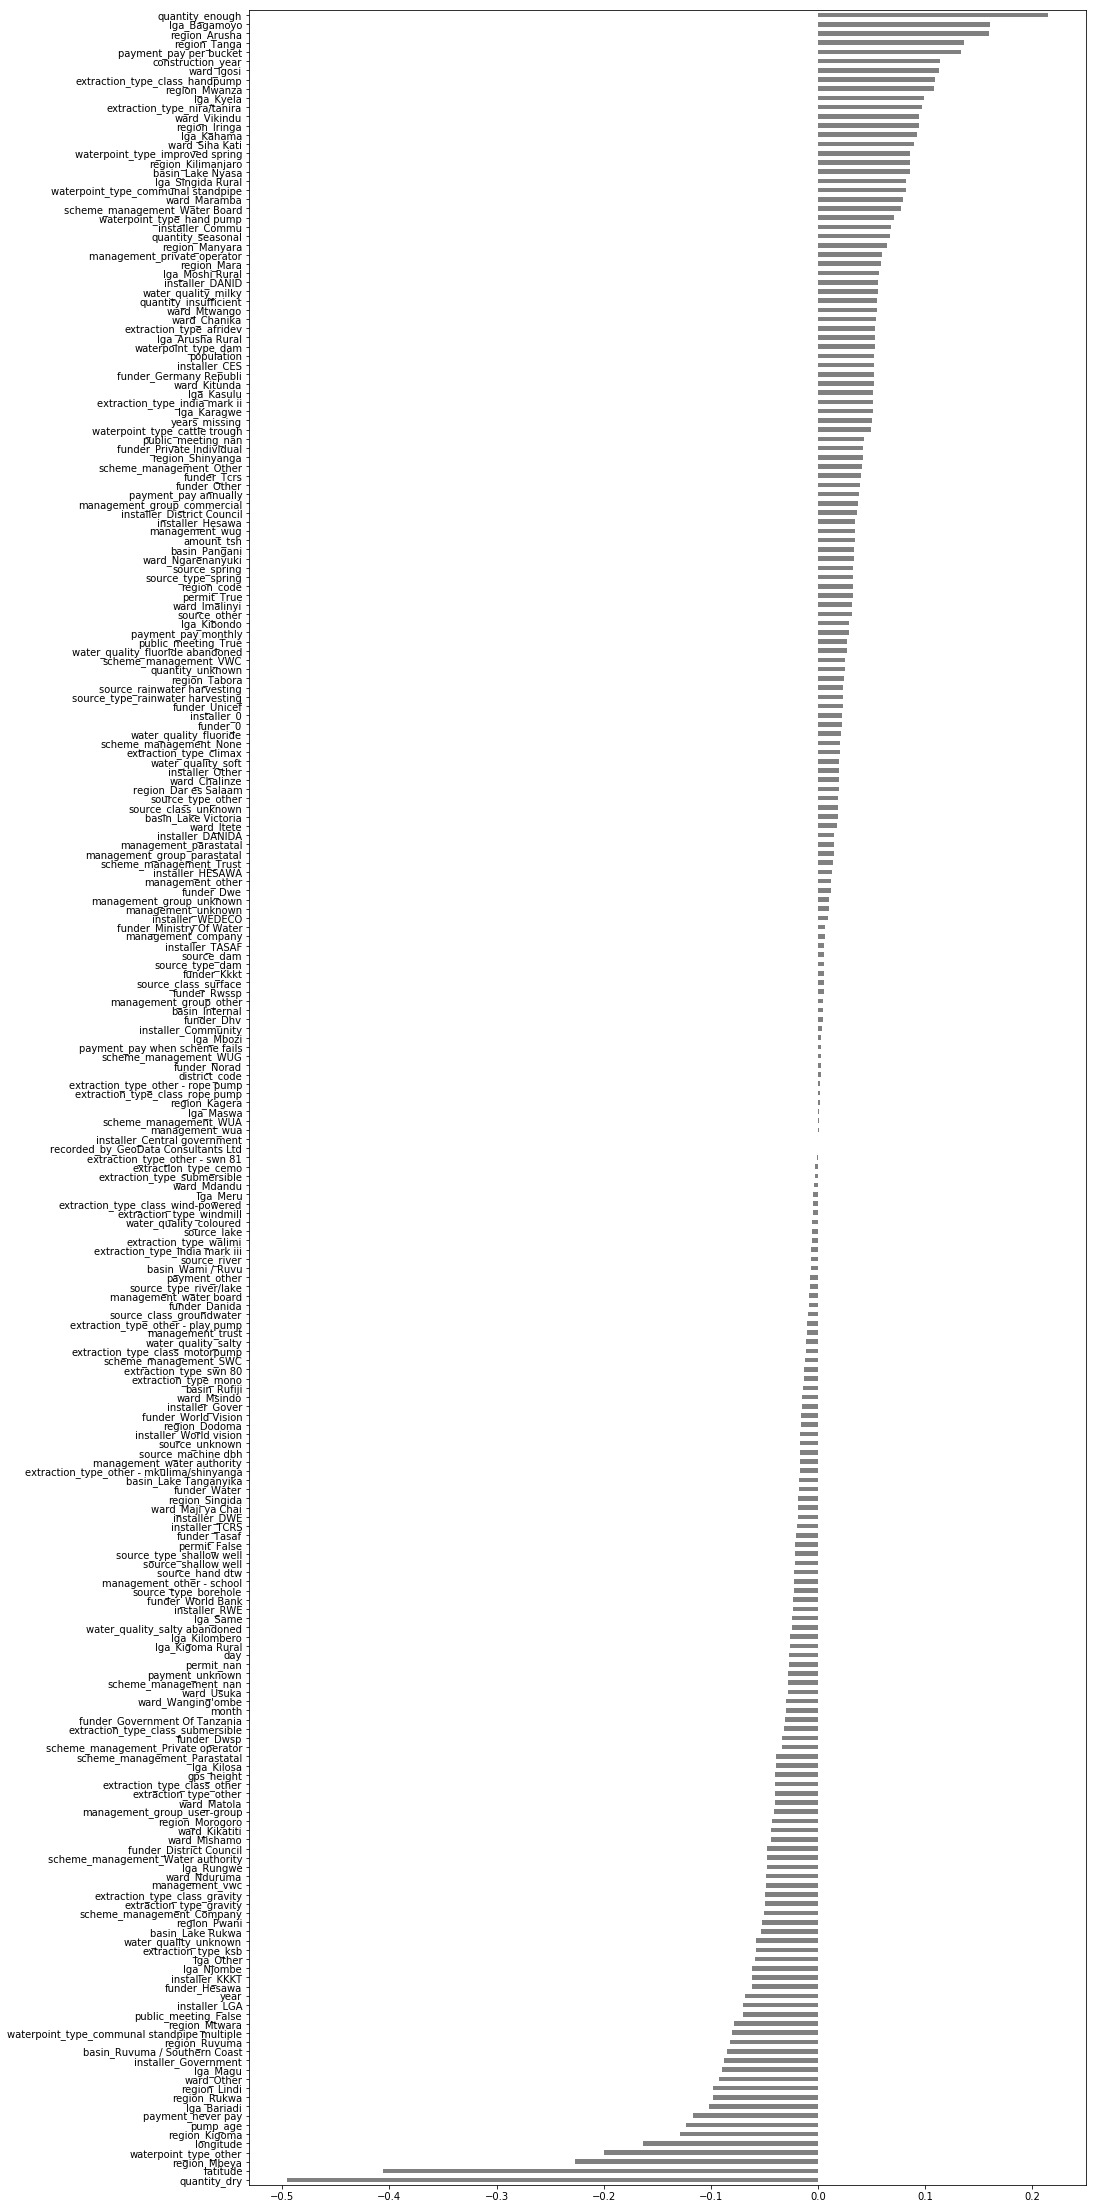

In [0]:
# import matplitlib inline, matplotlib.pyplot.
%matplotlib inline
import matplotlib.pyplot as plt
# create a model with the pipeline.named_steps['logisticregression'].
# create an encode with pipeline.named_steps['onehotencoder'].
model = pipeline.named_steps['logisticregression']
encoder = pipeline.named_steps['onehotencoder']
# create encoded_columns with encoder.transform(X_val).columns.
encoded_columns = encoder.transform(X_val).columns
# create coefficients with pd.Series(model.coef_[0], encoded_columns)
coefficients = pd.Series(model.coef_[0], encoded_columns)
# set the figure size
plt.figure(figsize=(15,40))
# bar plot the coefficients and sort with grey color.
coefficients.sort_values().plot.barh(color='grey');

## Create Data Frame Submission.

In [0]:
submission = sample_submission.copy()
submission['status_group'] = y_pred
submission.to_csv('submission-01.csv', index=False)

In [0]:
!head submission-01.csv

id,status_group
50785,non functional
51630,functional
17168,functional
45559,non functional
49871,functional
52449,functional
24806,functional
28965,non functional
36301,functional


In [0]:
from google.colab import files 
files.download('submission-01.csv')

## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Try other [scikit-learn scalers](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this problem, you may want to use the parameter `logistic=True`

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```